In [1]:
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt

In [2]:
m = gp.Model()

# SETS
I = [0,1,2,3,4] #job
J = [0,1,2,3,4] #job
K = [0,1,2]     #machine
#------------------------------------------------------------------------------------------------------------
#PARAMETERS
#Total number of machines can be used to perform job i
MO = [2,2,1,3,1]
#Processing time of job i
P = [4,7,5,6,1]
#Amount of job i
Q = [3,4,5,7,9]
#Set up time in case job j comes after job i
S = [[3,2,5,1,5],
     [4,1,5,3,5],
     [1,1,6,1,3],
     [1,3,3,1,5],
     [3,1,6,1,3]]
#Due data of job i
d = [20, 60, 50, 20, 30] #arttırmak gerekebilir feasiblity için
#Defective output of job j if it comes after job i
W = [[0,1,3,2,5],
     [3,0,8,1,5],
     [2,1,0,1,3],
     [3,1,5,0,4],
     [7,1,5,1,0]]
a = [20,50,30]

Set parameter Username
Academic license - for non-commercial use only - expires 2024-05-10


In [3]:
def optimization_model(epsilon, I, J, K, MO, P, Q, S, d, W, a):
    #DECISION VARIABLES
    x_0jk = m.addVars(J,K, vtype=GRB.BINARY, name = 'x_0jk') #1 if job j is the first job on machine k
    x_j0k = m.addVars(J,K, vtype=GRB.BINARY, name = 'x_j0k') #1 if job j is the last job on machine k
    x = m.addVars(I,J,K, vtype=GRB.BINARY, name = 'x') #1 if job j comes after job i in machine k
    y = m.addVars(I, K, vtype=GRB.BINARY, name = 'y') #1 if job i is processes on machine k
    q = m.addVars(I, K, lb = 0, vtype=GRB.INTEGER, name = 'q') #amount of job i processed on machine k
    Z = m.addVars(I, lb = 0, vtype=GRB.INTEGER, name = 'Z') #tardiness
    C = m.addVars(I, K, lb = 0, vtype=GRB.INTEGER, name = 'C') #completion time
    #OBJECTIVE FUNCTION 
    z1 = gp.quicksum(Z[i] for i in I)
    z2 = gp.quicksum(x[i,j,k]*W[i][j] for i in I for j in J for k in K)
    m.setObjective(z2, GRB.MINIMIZE)   
    #------------------------------------------------------------------------------------------------------------
    #CONSTRAINTS
    # epsilon contraint için
    m.addConstrs(z1 <= epsilon for i in I)

    # (1)
    m.addConstrs(gp.quicksum(q[i,k] for k in K) == Q[i] for i in I)
    # (2)
    m.addConstrs(y[i,k] >= (q[i,k]/Q[i]) for i in I for k in K)
    # (3)
    m.addConstrs(y[i,k] <= q[i,k] for i in I for k in K)
    # (4)
    m.addConstrs(x_0jk[j,k]+ gp.quicksum(x[i,j,k] for i in I) == y[j,k] for j in J for k in K)
    m.addConstrs(x_j0k[i,k]+ gp.quicksum(x[i,j,k] for j in J) == y[i,k] for i in I for k in K)
    # (5)
    m.addConstrs(x_0jk[i,k] * (q[i,k]*P[i]) <= C[i,k] for i in I for k in K)
    m.addConstrs(x[i,j,k] * (S[i][j] + C[i,k] + q[j,k]*P[j]) <= C[j,k] for i in I for j in J for k in K)
    # (6)
    m.addConstrs(C[i,k] - d[i] <= Z[i] for i in I for k in K)
    # (7)
    m.addConstrs(x[i,i,k] == 0 for i in I for k in K)
    # (8)
    m.addConstrs(gp.quicksum(x[i,j,k]*W[i][j] for i in I for j in J) <= a[k] for k in K)
    # (9)
    m.addConstrs(gp.quicksum(y[i,k] for k in K) <= MO[i] for i in I)
    # (10) 
    m.addConstrs(gp.quicksum(x_0jk[i,k] for i in I) == 1 for k in K)
    m.addConstrs(gp.quicksum(x_j0k[i,k] for i in I) == 1 for k in K)
    # (11) 
    m.addConstrs(gp.quicksum(y[i,k] for i in I) >= 1 for k in K)
    # (12) DENEME
    M = 100000
    m.addConstrs(C[i,k] >= y[i,k] for i in I for k in K)
    m.addConstrs(C[i,k] <= M*y[i,k] for i in I for k in K)
    m.optimize()
    
    try:
        obj_val = m.objVal
        objective1_value = z1.getValue()
        x_0jk_l = []
        x_j0k_l = []
        x_l = []
        C_l = []
        y_l = []
        q_l = []
        for v in x_0jk.values():
            if v.X != 0:
                x_0jk_l.append("{}: {:.2f}".format(v.varName, v.X))
                                
        for v in x_j0k.values():
            if v.X != 0:
                x_j0k_l.append("{}: {:.2f}".format(v.varName, v.X))
                
        for v in x.values():
            if v.X != 0:
                x_l.append("{}: {:.2f}".format(v.varName, v.X))
                
        for v in C.values():
            if v.X != 0:
                C_l.append("{}: {:.2f}".format(v.varName, v.X))
                
        for v in y.values():
            if v.X != 0:
                y_l.append("{}: {:.2f}".format(v.varName, v.X))
                
        for v in q.values():
            if v.X != 0:
                q_l.append("{}: {:.2f}".format(v.varName, v.X))
                
        return (round(objective1_value, 0), round(obj_val, 0), x_0jk_l, x_j0k_l, x_l, C_l, y_l, q_l)
    except AttributeError:
        return "Model Infeasible"

In [4]:
epsilon_list = []
epsilon = 32
flag = 1
step_size = 2
weaklynondominated = []
t = 0
x_0jk_liste = []
x_j0k_liste = []
x_liste = []
C_liste = []
y_liste = []
q_liste = []
while flag == 1:
    result = optimization_model(epsilon, I, J, K, MO, P, Q, S, d, W, a)
    if result == "Model Infeasible":
        print("There is no more point to search !!")
        flag = 0
    else:
        #print("epsilon:", epsilon)
        x_0jk_liste.append(result[2])
        x_j0k_liste.append(result[3])
        x_liste.append(result[4])
        C_liste.append(result[5])
        y_liste.append(result[6])
        q_liste.append(result[7])
        
        weaklynondominated.append(result[:2])
        epsilon_list.append(epsilon)
        epsilon = result[0] - step_size
        #epsilon_list.append(epsilon)
        
        
print(weaklynondominated)

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 147 rows, 155 columns and 535 nonzeros
Model fingerprint: 0x7fc87993
Model has 90 quadratic constraints
Variable types: 0 continuous, 155 integer (120 binary)
Coefficient statistics:
  Matrix range     [1e-01, 1e+05]
  QMatrix range    [1e+00, 7e+00]
  QLMatrix range   [1e+00, 6e+00]
  Objective range  [1e+00, 8e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+01]
Presolve added 24 rows and 0 columns
Presolve removed 0 rows and 21 columns
Presolve time: 0.01s
Presolved: 201 rows, 149 columns, 682 nonzeros
Variable types: 0 continuous, 149 integer (111 binary)

Root relaxation: objective 2.000000e+00, 94 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | In

Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1029 rows, 1085 columns and 3745 nonzeros
Model fingerprint: 0xd82aba4a
Model has 630 quadratic constraints
Variable types: 0 continuous, 1085 integer (840 binary)
Coefficient statistics:
  Matrix range     [1e-01, 1e+05]
  QMatrix range    [1e+00, 7e+00]
  QLMatrix range   [1e+00, 6e+00]
  Objective range  [1e+00, 8e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+01]

MIP start from previous solve produced solution with objective 9 (0.01s)
MIP start from previous solve produced solution with objective 4 (0.03s)
MIP start from previous solve produced solution with objective 3 (0.05s)
Loaded MIP start from previous solve with objective 3

Presolve removed 858 rows and 951 columns
Presolve time: 0.06s
Presolved: 201 rows, 149 columns, 682 nonzeros
Variable types: 0 continuous, 149 integer (111 binary)

Explored 0 nodes (0 simplex iterations) in 0.11 seconds (0.06 work u

MIP start from previous solve produced solution with objective 8 (0.13s)
MIP start from previous solve produced solution with objective 5 (0.14s)
Loaded MIP start from previous solve with objective 5

Presolve removed 1740 rows and 1881 columns
Presolve time: 0.16s
Presolved: 201 rows, 149 columns, 682 nonzeros
Variable types: 0 continuous, 149 integer (111 binary)

Explored 0 nodes (0 simplex iterations) in 0.31 seconds (0.17 work units)
Thread count was 8 (of 8 available processors)

Solution count 6: 5 8 9 ... 12

Optimal solution found (tolerance 1.00e-04)
Best objective 5.000000000000e+00, best bound 5.000000000000e+00, gap 0.0000%
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2058 rows, 2170 columns and 7490 nonzeros
Model fingerprint: 0x1f269785
Model has 1260 quadratic constraints
Variable types: 0 continuous, 21


Cutting planes:
  Learned: 3
  Gomory: 1
  Cover: 4
  Implied bound: 4
  MIR: 11
  StrongCG: 2
  Flow cover: 2
  GUB cover: 1
  Mod-K: 2
  RLT: 1
  Relax-and-lift: 4

Explored 81 nodes (1980 simplex iterations) in 0.50 seconds (0.23 work units)
Thread count was 8 (of 8 available processors)

Solution count 4: 8 9 14 15 

Optimal solution found (tolerance 1.00e-04)
Best objective 8.000000000000e+00, best bound 8.000000000000e+00, gap 0.0000%
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2352 rows, 2480 columns and 8560 nonzeros
Model fingerprint: 0x1eb00024
Model has 1440 quadratic constraints
Variable types: 0 continuous, 2480 integer (1920 binary)
Coefficient statistics:
  Matrix range     [1e-01, 1e+05]
  QMatrix range    [1e+00, 7e+00]
  QLMatrix range   [1e+00, 6e+00]
  Objective range  [1e+00, 8e+00]
  Bounds range

In [5]:
z1 = []
z2 = []
for i in range(len(weaklynondominated)):
    z2.append(weaklynondominated[i][1])
    z1.append(weaklynondominated[i][0])

In [6]:
# Post processing
nondominated_y = []
for w in weaklynondominated:
    nondominated_y.append(w[1])

nondominated_x = []
for w in weaklynondominated:
    nondominated_x.append(w[0])

nondominated_dict = dict(zip(nondominated_y, nondominated_x))

L1 = []
L2 = []
for n in nondominated_dict.values():
    L1.append(n)

for n in nondominated_dict.keys():
    L2.append(n)

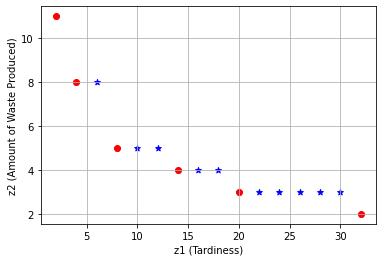

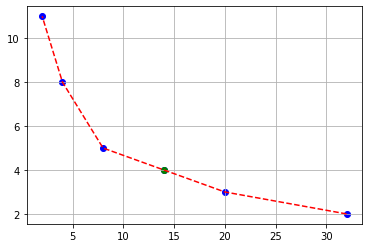

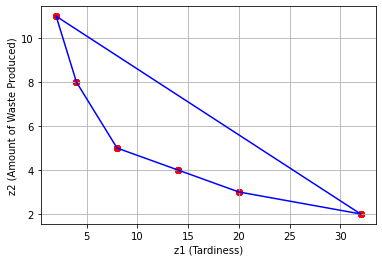

In [7]:
plt.scatter(z1, z2, color = 'blue', marker = '*')
plt.grid()
plt.xlabel("z1 (Tardiness)")
plt.ylabel("z2 (Amount of Waste Produced)")
plt.scatter(L1, L2, c="red")
plt.show()

# Only nondominated ones, nondominated frontier

# The convex hull
from scipy.spatial import ConvexHull
import numpy as np
objective_values = np.column_stack((L1, L2))
hull = ConvexHull(objective_values)

plt.scatter(L1, L2, c="blue")
plt.plot(L1, L2, c="red", linestyle="--")  # Dashed line style
plt.scatter(14.0, 4.0, c="green")
plt.grid()
plt.show()

for simplex in hull.simplices:
    plt.plot(objective_values[simplex, 0], objective_values[simplex, 1], "b-")
    plt.scatter(L1, L2, c="red")
plt.grid()
plt.xlabel("z1 (Tardiness)")
plt.ylabel("z2 (Amount of Waste Produced)")
plt.show()

In [8]:
nondominated_list = [(32.0, 2.0), (20.0, 3.0), (14.0, 4.0), (8.0, 5.0), (4.0, 8.0), (2.0, 11.0)]

for i in nondominated_list:
    search_index = weaklynondominated.index(i)
    print("Optimal Values:", i)
    print("epsilon:", epsilon_list[search_index])
    print("First Jobs:",x_0jk_liste[search_index])
    print("Last Jobs:", x_j0k_liste[search_index])
    print("Intermediate Jobs:", x_liste[search_index])
    print("Processed or not:", y_liste[search_index])
    print("Completion Time:",C_liste[search_index])
    print("Amount of job:",q_liste[search_index])
    print("--------------------------------------------------------------------------------------------")

Optimal Values: (32.0, 2.0)
epsilon: 32
First Jobs: ['x_0jk[0,2]: 1.00', 'x_0jk[2,0]: 1.00', 'x_0jk[4,1]: 1.00']
Last Jobs: ['x_j0k[1,2]: 1.00', 'x_j0k[2,0]: 1.00', 'x_j0k[3,1]: 1.00']
Intermediate Jobs: ['x[0,1,2]: 1.00', 'x[4,3,1]: 1.00']
Processed or not: ['y[0,2]: 1.00', 'y[1,2]: 1.00', 'y[2,0]: 1.00', 'y[3,1]: 1.00', 'y[4,1]: 1.00']
Completion Time: ['C[0,2]: 13.00', 'C[1,2]: 60.00', 'C[2,0]: 25.00', 'C[3,1]: 52.00', 'C[4,1]: 9.00']
Amount of job: ['q[0,2]: 3.00', 'q[1,2]: 4.00', 'q[2,0]: 5.00', 'q[3,1]: 7.00', 'q[4,1]: 9.00']
--------------------------------------------------------------------------------------------
Optimal Values: (20.0, 3.0)
epsilon: 20.0
First Jobs: ['x_0jk[0,0]: 1.00', 'x_0jk[2,2]: 1.00', 'x_0jk[4,1]: 1.00']
Last Jobs: ['x_j0k[1,0]: 1.00', 'x_j0k[3,1]: 1.00', 'x_j0k[3,2]: 1.00']
Intermediate Jobs: ['x[0,1,0]: 1.00', 'x[2,3,2]: 1.00', 'x[4,3,1]: 1.00']
Processed or not: ['y[0,0]: 1.00', 'y[1,0]: 1.00', 'y[2,2]: 1.00', 'y[3,1]: 1.00', 'y[3,2]: 1.00', 'y[4,1]: 